## Galaxy Classification type1

In [ ]:
! pip install tf-keras-vis tensorflow
! pip install astroNN
! pip install --upgrade --no-cache-dir gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 58.8 MB/s eta 0:00:00
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import h5py
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix


print("Num GPUs Avaialble: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Avaialble:  1


### Import the dataset and split the data

In [ ]:

from astroNN.datasets import load_galaxy10
from tensorflow.keras import utils
# from google.colab import drive
# drive.mount('/content/drive')


# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
# with h5py.File('/content/drive/MyDrive/Galaxy10_DECals.h5', 'r') as F:
#     images = np.array(F['images'])
#     labels = np.array(F['ans'])
images, labels = load_galaxy10()

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.2)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]
train_images.shape

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [02:46<00:00, 17.1MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [02:54, 15.7MB/s]                            


(14188, 256, 256, 3)

In [ ]:
def galaxyMap(index):
  arr = {
      0: "Disturbed Galaxies",
      1: "Merging Galaxies",
      2: "Round Smooth Galaxies",
      3: "In-between Round Smooth Galaxies",
      4: "Cigar Shaped Smooth Galaxies",
      5: "Barred Spiral Galaxies",
      6: "Unbarred Tight Spiral Galaxies",
      7: "Unbarred Loose Spiral Galaxies",
      8: "Edge-on Galaxies without Bulge",
      9: "Edge-on Galaxies with Bulge"
  }
  return arr[index]

## Display the first ten images




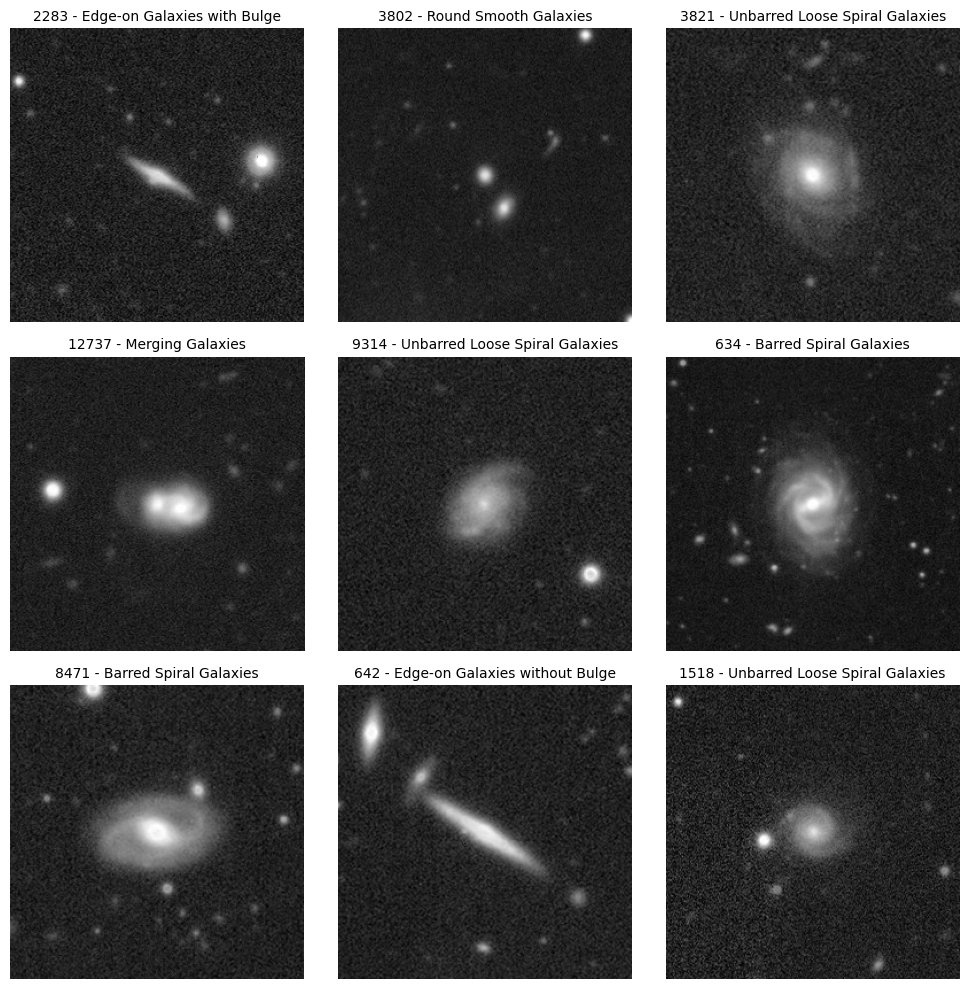

In [ ]:
# Choose 9 image indexes randomly
num_images_to_display = 9
random_indices = np.random.randint(0, len(train_images), num_images_to_display)

# build a 3x3 figure
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# draw images
for i, ax in enumerate(axes.flat):
    index = random_indices[i]
    image = train_images[index]


    rgb_image = np.mean(image, axis=2)  # Combine the average values of 3 bands

    ax.imshow(rgb_image, cmap='gray')  # Use gray image

    index_classification = np.argmax(train_labels[index])

    ax.set_title(f"{ index } - { galaxyMap(index_classification) }", fontsize = 10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#For test
num_images = 2000
selected_images = train_images[:num_images]
selected_labels = train_labels[:num_images]

### Data preprocess

In [ ]:
import itertools
#Generator
train_datagen = ImageDataGenerator(
    rescale = 1./256,#Generalize the images' size to 255
    validation_split = 0.2,#Split 20 percent validation data of training data
    rotation_range = 5,#set a rotation range to 20 degree
    width_shift_range = 0.1,
)

test_datagen = ImageDataGenerator(
    rescale = 1./256,
)

traingen = train_datagen.flow(
    x = selected_images,
    y = selected_labels,
    batch_size=16,
    subset = 'training',
    shuffle = True
)
traingen = itertools.cycle(traingen)
valgen = train_datagen.flow(
    x = selected_images,
    y = selected_labels,
    batch_size = 16,
    subset = 'validation',
    shuffle = False
)
valgen = itertools.cycle(valgen)
# testgen = test_datagen.flow_from_dataframe(
#     x = test_images,
#     y = test_labels,
#     target_size = (255,255),
#     subset = 'test',
# )



In [ ]:
model_1 = Sequential()

#Convolutional
model_1.add(tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (256,256,3)))
model_1.add(tf.keras.layers.BatchNormalization(synchronized=True))
model_1.add(tf.keras.layers.AveragePooling2D((2,2)))

model_1.add(tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'))
model_1.add(tf.keras.layers.BatchNormalization(synchronized=True))
model_1.add(tf.keras.layers.AveragePooling2D((2,2)))

model_1.add(tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'))
model_1.add(tf.keras.layers.BatchNormalization(synchronized=True))
model_1.add(tf.keras.layers.AveragePooling2D((2,2)))

model_1.add(tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'))
model_1.add(tf.keras.layers.BatchNormalization(synchronized=True))
model_1.add(tf.keras.layers.AveragePooling2D((2,2)))

model_1.add(tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'))
model_1.add(tf.keras.layers.BatchNormalization(synchronized=True))
model_1.add(tf.keras.layers.AveragePooling2D((2,2)))




#Flatten
model_1.add(tf.keras.layers.Flatten())

#Fully connected
# model_1.add(tf.keras.layers.Dense(128,activation = 'relu'))
model_1.add(tf.keras.layers.Dense(128,activation = 'relu'))
model_1.add(tf.keras.layers.BatchNormalization(synchronized=True))
model_1.add(tf.keras.layers.Dense(64,activation = 'relu'))
model_1.add(tf.keras.layers.BatchNormalization(synchronized=True))
model_1.add(tf.keras.layers.Dense(10,activation = 'softmax'))

model_1.summary()

model_1.compile(optimizer = 'Nadam',loss = 'categorical_crossentropy',metrics = ['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 average_pooling2d (Average  (None, 127, 127, 32)      0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [ ]:
#Training
# history = model_1.fit(
#     datagen.flow(train_data, train_labels),
#     steps_per_epoch=train_data.shape[0] // 16,
#     epochs=10,
#     validation_data=datagen.flow(validation_data, validation_labels),
#     validation_steps=validation_data.shape[0] // 16)

# history = model_1.fit(train_images,train_labels,validation_split = 0.2,epochs = 40, batch_size = 128)

history = model_1.fit_generator(
    traingen,
    steps_per_epoch = len(selected_images)//32,
    epochs = 25,
    validation_data = valgen,
    validation_steps = len(selected_images)//32

)

<ipython-input-9-b9e49c709968>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/25
62/62 [==============================] - 44s 405ms/step - loss: 2.2961 - accuracy: 0.2480 - val_loss: 2.5138 - val_accuracy: 0.1250
Epoch 2/25
62/62 [==============================] - 24s 400ms/step - loss: 1.9120 - accuracy: 0.3367 - val_loss: 2.9134 - val_accuracy: 0.1452
Epoch 3/25
62/62 [==============================] - 24s 392ms/step - loss: 1.8464 - accuracy: 0.3327 - val_loss: 3.8577 - val_accuracy: 0.1593
Epoch 4/25
62/62 [==============================] - 23s 380ms/step - loss: 1.7642 - accuracy: 0.3770 - val_loss: 4.0381 - val_accuracy: 0.1442
Epoch 5/25
62/62 [==============================] - 22s 355ms/step - loss: 1.6793 - accuracy: 0.3911 - val_loss: 4.3571 - val_accuracy: 0.1653
Epoch 6/25
62/62 [==============================] - 19s 304ms/step - loss: 1.5698 - accuracy: 0.4234 - val_loss: 2.9879 - val_accuracy: 0.2288
Epoch 7/25
62/62 [==============================] - 14s 233ms/step - loss: 1.5437 - accuracy: 0.4325 - val_loss: 2.9625 - val_accuracy: 0.2147

### Plot the accuracy and loss of training and validation

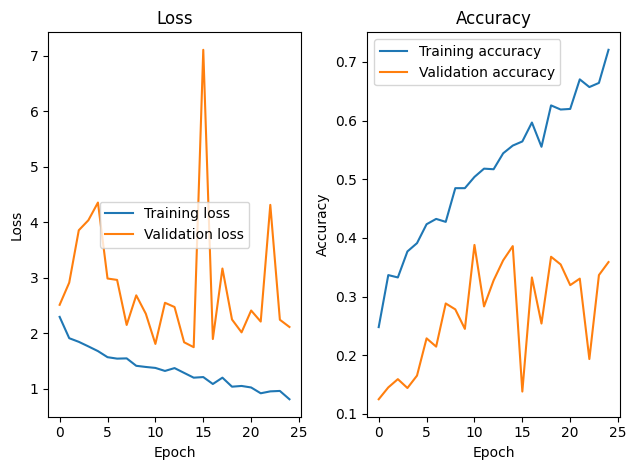

In [ ]:

plt.subplot(1,2,1)
plt.plot(history.history['loss'],label = 'Training loss')
plt.plot(history.history['val_loss'],label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Get the test result

In [ ]:
test_loss, test_accuracy = model_1.evaluate(test_images, test_labels)

#Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

111/111 [==============================] - 2s 15ms/step - loss: 893.8354 - accuracy: 0.2097
Test Loss: 893.8353881835938
Test Accuracy: 0.20969560742378235


### Classifcation Report

In [ ]:
y_true = test_labels
y_pred = model_1.predict(test_images)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true_classes = np.argmax(y_true,axis = 1)

print(y_true_classes)
print(y_pred_classes)

report = classification_report(y_true_classes, y_pred_classes)

print(f"Classification Report: {report}")

111/111 [==============================] - 1s 11ms/step
[1 3 9 ... 0 3 3]
[3 3 3 ... 6 3 3]
Classification Report:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       215
           1       0.00      0.00      0.00       388
           2       0.15      0.03      0.05       540
           3       0.17      0.91      0.28       391
           4       0.00      0.00      0.00        76
           5       0.00      0.00      0.00       445
           6       0.22      0.55      0.32       327
           7       0.00      0.00      0.00       544
           8       0.80      0.01      0.03       288
           9       0.36      0.56      0.44       334

    accuracy                           0.21      3548
   macro avg       0.17      0.21      0.11      3548
weighted avg       0.16      0.21      0.11      3548



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### Draw ROC and AUC curve

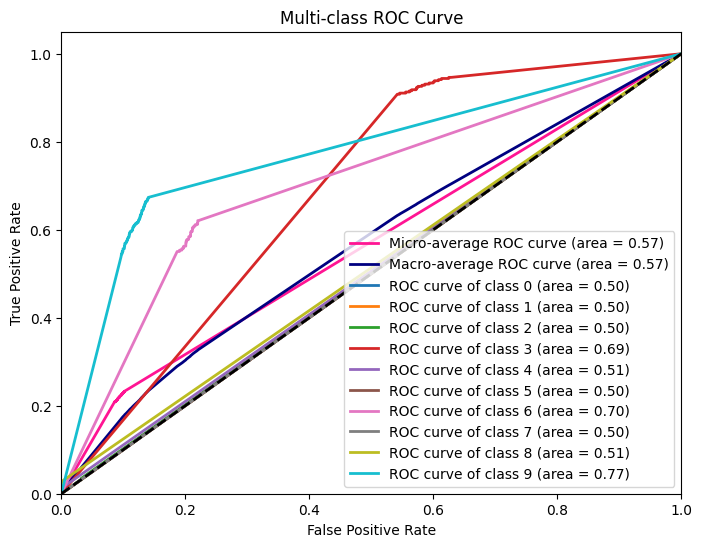

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Draw the ROC curve
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate the average micro ROC and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculate the average macro ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='-', linewidth=2, label='Micro-average ROC curve (area = {0:0.2f})'
       ''.format(roc_auc["micro"]))

plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='-', linewidth=2, label='Macro-average ROC curve (area = {0:0.2f})'
       ''.format(roc_auc["macro"]))


for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
# Display confusion matrix
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Get the confusion matrix

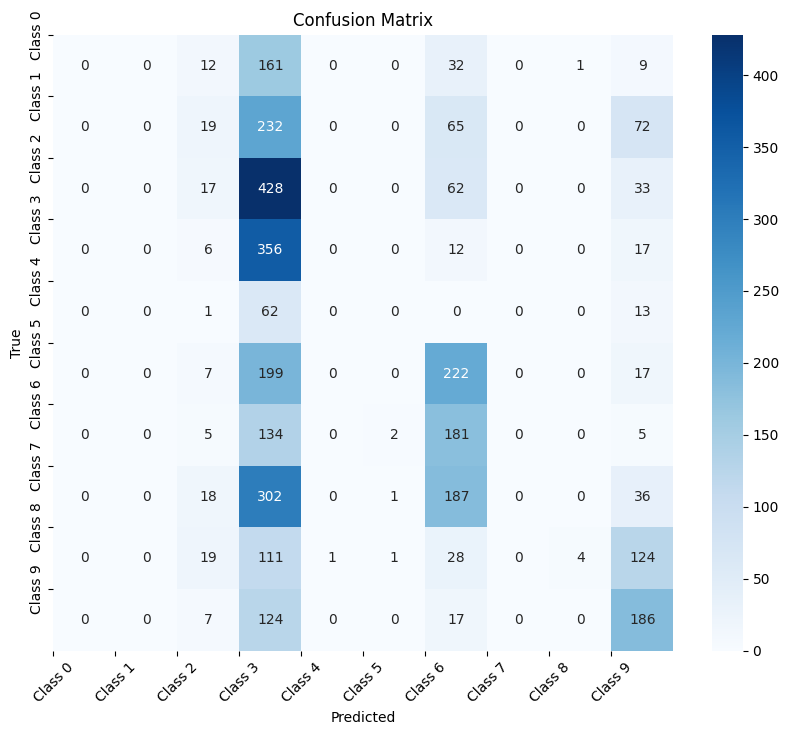

In [ ]:
# Calculate confusion matrix
confusion_mtx = confusion_matrix(np.argmax(y_true, axis=1), y_pred_classes)

# Draw the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)

# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')

# Add the classes
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Display confusion matrix
plt.title('Confusion Matrix')
plt.show()